In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, grad, jit, random
from flax import nnx
import optax

import matplotlib
import matplotlib.pyplot as plt

import zarr
import xarray as xr

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def split_data(data, lag, horizon):
    horizon = horizon-1
    y_t = np.moveaxis(data[(lag + horizon):][:,None], 1, 3)
    x_t = np.stack([data[(lag-i-1):(-(i+1+horizon))] for i in range(lag)], axis = 3)
    return x_t, y_t

In [86]:
class Block(nnx.Module):
    def __init__(self, dim, dim_out, rngs = nnx.Rngs):
        self.proj = nnx.Conv(dim, dim_out, (3, 3), padding = 'CIRCULAR', rngs = rngs)
        self.norm = nnx.BatchNorm(dim_out, rngs = rngs)

    def __call__(self, x):
        x = self.proj(x)
        x = self.norm(x)
        return nnx.silu(x)

class ResnetBlock(nnx.Module):
    def __init__(self, dim, dim_out, rngs = nnx.Rngs):
        self.block1 = Block(dim, dim_out, rngs = rngs)
        self.block2 = Block(dim_out, dim_out, rngs = rngs)
        self.block3 = Block(dim_out, dim_out, rngs = rngs)
        self.res_conv = nnx.Conv(dim, dim_out, (1, 1), rngs = rngs)

    def __call__(self, x):
        h = self.block1(x)
        h = self.block2(h)
        h = self.block3(h)
        return h + self.res_conv(x)

class ClimateNO(nnx.Module):
    def __init__(self, lag, rngs = nnx.Rngs):
        self.enc = nnx.Conv(lag, 30, (1, 1), rngs = rngs)
        self.res1 = ResnetBlock(30, 32, rngs = rngs)
        self.res2 = ResnetBlock(32, 16, rngs = rngs)
        self.res3 = ResnetBlock(16, 1, rngs = rngs)
        self.dec = nnx.Conv(1, 1, (1, 1), rngs = rngs)

        self.up1 = nnx.ConvTranspose(30, 30, (3, 3), strides = (2, 2), padding = 'CIRCULAR', rngs = rngs)
        self.up2 = nnx.ConvTranspose(32, 32, (3, 3), strides = (2, 2), padding = 'CIRCULAR', rngs = rngs)
        self.up3 = nnx.ConvTranspose(16, 16, (3, 3), strides = (2, 2), padding = 'CIRCULAR', rngs = rngs)

    def __call__(self, x):
        h = self.enc(x)
        h = self.up1(h)
        h = self.res1(h)
        h = self.up2(h)
        h = self.res2(h)
        h = self.up3(h)
        h = self.res3(h)
        h = self.dec(h)
        return h

In [87]:
def train_step(model, optimizer, x, y):
  def loss_fn(model):
    y_pred = model(x)  # call methods directly
    return ((y_pred - y) ** 2).mean()

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # in-place updates

  return loss

train_step = nnx.jit(train_step)

In [88]:
tas_hr.shape

(1980, 192, 288, 1)

In [89]:
tas_hr = jnp.array(np.load('./data/cesm_tas_hr.npy')[:,:,:,None])
tas_lr = jnp.array(np.load('./data/cesm_tas_lr.npy')[:,:,:,None])
# tas_lr = jax.image.resize(tas_lr, (tas_lr.shape[0], 192, 288, 1), 'nearest')

In [93]:
xtrain = tas_lr[0:1000]
ytrain = tas_hr[0:1000]

model = ClimateNO(1, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(model, optax.adam(1e-3))
rng = random.PRNGKey(0)

epochs = 100
batch = 25
niter = int(1000/batch)
trace = []

for b in trange(epochs):
    for i in trange(niter, leave = False):
        xt = xtrain[(i*batch):((i+1)*batch)]
        yt = ytrain[(i*batch):((i+1)*batch)]
    
        loss = train_step(model, optim, xt, yt)
        trace.append(loss)
    print(f'loss: {loss}', end='\r')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 11.565596580505371

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 6.49937629699707

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 4.748834133148193

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 3.735823154449463

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 3.10536789894104

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 2.7378034591674805

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 2.4644582271575928

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 2.259617328643799

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 2.1339759826660156

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 2.0564067363739014

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.92960786819458

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.8830671310424805

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.782822608947754

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.8116116523742676

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.7125135660171509

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.724257469177246

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.596993327140808

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.6434608697891235

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.5300310850143433

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.5041494369506836

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.456681728363037

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.4476306438446045

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.4129283428192139

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.3891364336013794

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.3295772075653076

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.3309990167617798

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.2886230945587158

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.301653265953064

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.2268708944320679

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.202994465827942

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.207582950592041

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.1510655879974365

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.168541431427002

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.125236988067627

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.1131364107131958

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.1477985382080078

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.089924931526184

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.0979349613189697

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.038437843322754

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.0447973012924194

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.0656893253326416

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.070469617843628

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 1.0079158544540405

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.9973562359809875

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.95921790599823

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.9613595604896545

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.9487068057060242

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.9501175284385681

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.9114142060279846

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.9467241764068604

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.9377369284629822

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.9539821743965149

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.9292812943458557

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.8923320770263672

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.8737813830375671

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.9113313555717468

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.8670218586921692

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.8505796194076538

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.8335282802581787

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.8753749132156372

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.8123692274093628

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.8184332251548767

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.8084098100662231

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7953980565071106

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7974911332130432

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7934232354164124

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.8150029182434082

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7763182520866394

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7912610173225403

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7734856009483337

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7910418510437012

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7660508155822754

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7428891062736511

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7649345993995667

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7914440631866455

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7538923621177673

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7315027117729187

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7541173100471497

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7280339598655701

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7234790921211243

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7483104467391968

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7116838693618774

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7114924192428589

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.704830527305603

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.6947981119155884

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7227059602737427

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.6793019771575928

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7115182876586914

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7084563970565796

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.6746178865432739

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.679096519947052

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.6647597551345825

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.6866286993026733

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7455733418464661

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.7861437797546387

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.667949378490448

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.6547902822494507

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.6464645862579346

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.6569623947143555

  0%|          | 0/40 [00:00<?, ?it/s]

loss: 0.6487723588943481

In [101]:
y = model(xt[0:1])

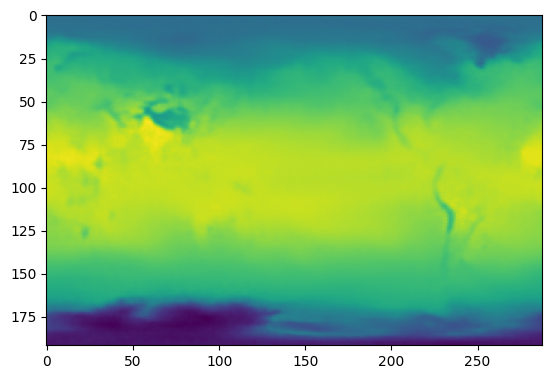

In [102]:
plt.imshow(y[0,:,:,0])

In [98]:
import os
import orbax.checkpoint as ocp

# extract state
_, state = nnx.split(model)

# save
checkpointer = ocp.StandardCheckpointer()
checkpointer.save(os.getcwd() + '/models/' + 'cesm_state', state)

In [6]:
lag = 24
horizon = 4
epochs = 5
batch = 64
groups = 10
niter = int(5200/batch)
trace = []

model = ClimateNO(lag, rngs=nnx.Rngs(0))
optim = nnx.Optimizer(model, optax.adam(1e-3))
rng = random.PRNGKey(0)

for b in trange(epochs):

    for g in trange(groups, leave = False):
        xtrain, ytrain = split_data(dtrain[(g*5200):((g+1)*5200)], lag, horizon)
        rng, perm_rng = random.split(rng, 2)
        xtrain = random.permutation(perm_rng, xtrain)
        ytrain = random.permutation(perm_rng, ytrain)
    
        for i in trange(niter, leave = False):
            xt = xtrain[(i*batch):((i+1)*batch)]
            yt = ytrain[(i*batch):((i+1)*batch)]
    
            loss = train_step(model, optim, xt, yt)
            trace.append(loss)
    print(f'loss: {loss}', end='\r')


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

loss: 3.4728071689605713

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

loss: 2.988978624343872

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

loss: 2.9423558712005615

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

loss: 2.833552360534668

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

loss: 2.9260263442993164

In [7]:
import os
import orbax.checkpoint as ocp

# extract state
_, state = nnx.split(model)

# save
checkpointer = ocp.StandardCheckpointer()
checkpointer.save(os.getcwd() + '/models/' + 'era5_small_state', state)

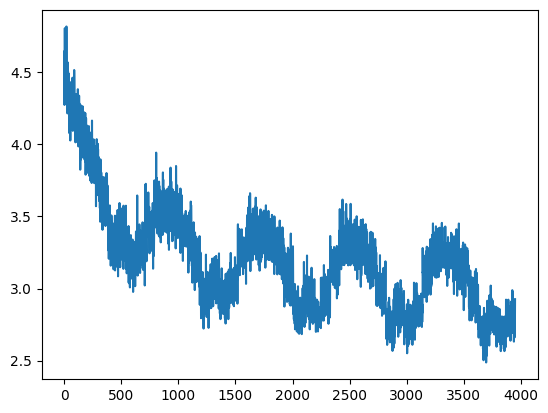

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/tharris/climate/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/tharris/climate/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/tharris/climate/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/tharris/climate/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever
    self._run_once()
  File "/usr/lib/python3.12/asyncio/base_events.py", line 1972, in _run_once
    handle = self._ready.popleft()
             ^^^^^^^^^^^^^^^^^^^^^
IndexError: pop from an empty deque


In [8]:
plt.plot(trace[100:])